# Computing *k* at the block and sub-block level serially and in parallel

10-01-2021 | nmarchio@uchicago.edu | Mansueto Institute

#### Conda environment setup
```
conda create --name pygeos_env python=3.9.5
source activate pygeos_env
conda config --env --add channels conda-forge
conda config --env --set channel_priority strict
conda install pygeos --channel conda-forge
conda install geopandas
conda install gdal --channel conda-forge
conda install -c conda-forge pyarrow
conda install libpysal
conda install dask
conda install time 
```
#### Additional installs for notebooks
```
conda install ipykernel
conda install -c conda-forge notebook
conda install -c conda-forge nb_conda_kernels
conda install jupyter
python -m ipykernel install --user --name=pygeos_env
```

In [1]:
import time
import warnings
warnings.filterwarnings('ignore', message='.*distributed.diskutils - INFO - *')
from dask.distributed import Client
client = Client(n_workers=4) # adjust as needed
import dask.bag as db
import dask

In [2]:
import pygeos
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
import pyarrow
import re
import os
gpd.options.use_pygeos = True

In [3]:
def build_blocks(gadm_data, osm_data, gadm_level, gadm_code):
    """
    Returns a GeoDataFrame containing all blocks in a GADM
    Args:
        gadm_data: GeoDataFrame, containing GADM delineations (downloaded from https://gadm.org/data.html)
        osm_data: PyGEOS geometry array, of linestrings that delineate blocks within GADMs (i.e., OSM linestrings from from http://download.geofabrik.de/)
        gadm_level: string, integer representing most detailed GID_* column in gadm_data
        gadm_code: string, unique identification code for each GADM GID_* column in gadm_data
    Returns:
        GeoDataFrame with enclosed block delineation geometries for a given 'gadm_code', each block is assigned a unique 'block_id'.
    """
    gadm_data = pygeos.from_shapely(gadm_data[gadm_data['GID_'+ gadm_level] == gadm_code]['geometry'])
    osm_data = pygeos.intersection(pygeos.multilinestrings(osm_data),gadm_data)
    gadm_data = pygeos.line_merge(pygeos.multilinestrings(pygeos.get_exterior_ring(gadm_data)))
    gadm_blocks = pygeos.union(osm_data[0],gadm_data)
    gadm_blocks = pygeos.polygonize_full([gadm_blocks])
    gadm_blocks = gpd.GeoDataFrame({"country_code": gadm_code[0:3], "gadm_code": gadm_code, "geometry": gpd.GeoSeries([pygeos.to_shapely(pygeos.normalize(gadm_blocks[0]))])}, crs=4326).explode()         
    gadm_blocks = gadm_blocks.reset_index(drop=True)
    gadm_blocks = gadm_blocks.assign(block_id = [gadm_code + '_' + str(x) for x in list(gadm_blocks.index)])
    gadm_blocks = gadm_blocks[['block_id','gadm_code','country_code','geometry']].to_crs(epsg=3395)
    return gadm_blocks


In [4]:
def index_buildings(gadm_block_data, bldg_data):
    """
    Returns a GeoDataFrame containing 
    Args:
        gadm_block_data: GeoDataFrame, output returned from build_blocks() function
        bldg_data: GeoDataFrame, containing building geometries
    Returns:
        GeoDataFrame with building geometries mapped to 'block_id','gadm_code','country_code'.
    """
    gadm_block_data = gadm_block_data.to_crs(epsg=3395)
    bldg_data = bldg_data.to_crs(epsg=3395)
    bldg_points = bldg_data.copy()
    bldg_points['geometry'] = bldg_points.centroid
    bldg_index = bldg_points.sindex
    index_bulk = bldg_index.query_bulk(gadm_block_data['geometry'], predicate="intersects")
    blocks_buildings_map = pd.DataFrame({'index_blocks': index_bulk[0], 'index_buildings': index_bulk[1]})
    blocks_buildings_map = blocks_buildings_map.merge(bldg_data[['geometry']], how = 'left', left_on='index_buildings', right_index=True)
    blocks_buildings_map = blocks_buildings_map.merge(gadm_block_data[['block_id','gadm_code','country_code']], left_on='index_blocks', right_index=True)
    bldg_data = gpd.GeoDataFrame(blocks_buildings_map[['block_id','gadm_code','country_code','geometry']]).to_crs(epsg=3395)
    return bldg_data


In [5]:
def compute_k(block_data, bldg_data, block_col, block_id, street_linestrings=None):
    """
    Returns a GeoDataFrame containing k-complexity value for each block
    Args:
        block_data: GeoDataFrame, output returned from build_blocks() function
        bldg_data: GeoDataFrame, output returned from index_buildings() function
        block_col: string, column that contains the block_id codes (present in block_data and bldg_data)
        block_id: string, unique identification code of block_id string in block_col
        street_linestrings: PyGEOS geometry array, linestrings representing street accesses (optional)
    Returns:
        GeoDataFrame with block geometries and the columns: 
            'block_id','block_area','building_area','building_count','building_layers','k_complexity'
    """
    block_layers = [] 

    bldg_data = bldg_data[bldg_data[block_col] == block_id].to_crs(epsg=3395)
    block_data = block_data[block_data[block_col] == block_id].to_crs(epsg=3395) 
    
    country_code = block_data['country_code'].unique()[0] 
    gadm_code = block_data['gadm_code'].unique()[0] 
    
    block_area = round(pygeos.area(pygeos.multipolygons(pygeos.from_shapely(block_data['geometry']))),2)
    bldg_array = pygeos.from_shapely(bldg_data['geometry'])
    bldg_area_list = pygeos.area(bldg_array)
    bldg_area = round(sum(bldg_area_list),2)
    bldg_count = np.sum(pygeos.get_num_geometries(bldg_array))
        
    if bldg_count not in [1,0]:
            
        bldg_data["geometry"] = bldg_data.centroid
        building_points = pygeos.multipoints(pygeos.from_shapely(bldg_data["geometry"]))
        points = pygeos.get_parts(building_points)
        voronoi = pygeos.get_parts(pygeos.voronoi_polygons(building_points))
        block = pygeos.from_shapely(block_data['geometry'])
        if not pygeos.is_valid(block): block = pygeos.make_valid(block)
        block_parcels = pygeos.intersection(block, voronoi)    
        bldg_count = np.sum(pygeos.get_num_geometries(block_parcels))

        if street_linestrings is not None:
            street_linestrings = pygeos.intersection(pygeos.multilinestrings(street_linestrings),block)
            block_intersect = pygeos.intersects(street_linestrings,block_parcels)
            block_parcels_outer = block_parcels[block_intersect]
            block_layers.append( str(np.sum(pygeos.get_num_geometries(block_parcels_outer))))
            block_depth = len(block_layers)
            block_parcels = block_parcels[~block_intersect]

        parcel_residual = np.sum(pygeos.get_num_geometries(block_parcels))

        while parcel_residual > 0:

            block_reduced = pygeos.coverage_union_all(block_parcels_outer)
            block_parcels_inner = block_parcels[~pygeos.touches(block_parcels,block_reduced)]      
            block_parcels_outer = block_parcels[pygeos.touches(block_parcels,block_reduced)] 
            #block_reduced = pygeos.coverage_union_all(block_parcels)
            #center = pygeos.get_coordinates(pygeos.centroid(block_reduced)).tolist()
            #block_interior = pygeos.apply(block_reduced, lambda x: ((x - center)*.9999 + center) )
            #block_exterior = pygeos.difference(block_reduced, block_interior)
            #block_ring = pygeos.intersects(block_exterior, block_parcels)
            #block_parcels_outer = block_parcels[block_ring]
            #block_parcels_inner = block_parcels[~block_ring]
            block_parcels = block_parcels_inner.copy()
            parcel_residual = np.sum(pygeos.get_num_geometries(block_parcels_inner))
            if parcel_residual == 0: 
                block_layers.append( str(np.sum(pygeos.get_num_geometries(block_parcels_outer))))
                block_depth = len(block_layers)
                break
            block_layers.append( str(np.sum(pygeos.get_num_geometries(block_parcels_outer))))
            block_depth = len(block_layers) 
        else:
            block_depth = len(block_layers)
            
    else:
        block_layers.append( str(bldg_count))
        block_depth = len(block_layers)
        
    data = gpd.GeoDataFrame.from_dict({'block_id': [block_id], 
                                       'gadm_code': gadm_code,
                                       'country_code': country_code,
                                       'block_area': block_area,
                                       'building_area': bldg_area,
                                       'building_count': bldg_count,
                                       'building_layers': ','.join(block_layers), 
                                       'k_complexity': [block_depth], 
                                       'geometry': block_data['geometry']}).to_crs(epsg=4326)
    return data



In [6]:
def compute_layers(block_data, bldg_data, block_col, block_id, street_linestrings=None):
    """
    Returns a GeoDataFrame containing k-complexity layers in each row for a block
    Args:
        block_data: GeoDataFrame, output returned from build_blocks() function
        bldg_data: GeoDataFrame, output returned from index_buildings() function
        block_col: string, column that contains the block_id codes (present in block_data and bldg_data)
        block_id: string, unique identification code of block_id string in block_col
        street_linestrings: PyGEOS geometry array, linestrings representing street accesses (optional)
    Returns:
        GeoDataFrame with block-layer geometries and the columns: 
            'block_id','gadm_code','country_code','building_count','k_complexity'
    """
    block_layers = [] 
    block_layers_geometry = []
    k_complexity = []
    bldg_data = bldg_data[bldg_data[block_col] == block_id].to_crs(epsg=3395)
    block_data = block_data[block_data[block_col] == block_id].to_crs(epsg=3395) 
    country_code = block_data['country_code'].unique()[0] 
    gadm_code = block_data['gadm_code'].unique()[0] 
    bldg_array = pygeos.from_shapely(bldg_data['geometry'])
    bldg_count = np.sum(pygeos.get_num_geometries(bldg_array))
    
    if bldg_count not in [1,0]:
        bldg_data["geometry"] = bldg_data.centroid
        building_points = pygeos.multipoints(pygeos.from_shapely(bldg_data["geometry"]))
        points = pygeos.get_parts(building_points)
        voronoi = pygeos.get_parts(pygeos.voronoi_polygons(building_points))
        block = pygeos.from_shapely(block_data['geometry'])
        if not pygeos.is_valid(block): block = pygeos.make_valid(block)
        block_parcels = pygeos.intersection(block, voronoi)    
        bldg_count = np.sum(pygeos.get_num_geometries(block_parcels))
        
        if street_linestrings is not None:
            street_linestrings = pygeos.intersection(pygeos.multilinestrings(street_linestrings),block)
            block_intersect = pygeos.intersects(street_linestrings,block_parcels)
            block_parcels_outer = block_parcels[block_intersect]
            block_layers.append(np.sum(pygeos.get_num_geometries(block_parcels_outer)))
            block_layers_geometry.append(pygeos.geometrycollections(block_parcels_outer))
            block_depth = len(block_layers)
            k_complexity.append(block_depth)
            block_parcels = block_parcels[~block_intersect]
            
        parcel_residual = np.sum(pygeos.get_num_geometries(block_parcels))
        
        while parcel_residual > 0:
            block_reduced = pygeos.coverage_union_all(block_parcels_outer)
            block_parcels_inner = block_parcels[~pygeos.touches(block_parcels,block_reduced)]      
            block_parcels_outer = block_parcels[pygeos.touches(block_parcels,block_reduced)] 
            block_parcels = block_parcels_inner.copy()
            parcel_residual = np.sum(pygeos.get_num_geometries(block_parcels_inner))
            
            if parcel_residual == 0: 
                block_layers.append(np.sum(pygeos.get_num_geometries(block_parcels_outer)))
                block_layers_geometry.append(pygeos.geometrycollections(block_parcels_outer))
                block_depth = len(block_layers)
                k_complexity.append(block_depth)
                break
                
            block_layers.append(np.sum(pygeos.get_num_geometries(block_parcels_outer)))
            block_layers_geometry.append(pygeos.geometrycollections(block_parcels_outer))
            block_depth = len(block_layers) 
            k_complexity.append(block_depth)
        else:
            block_depth = len(block_layers)
            k_complexity.append(block_depth)
    else:
        block_layers.append(bldg_count)
        block_layers_geometry.append(pygeos.geometrycollections(block_parcels_outer))
        block_depth = len(block_layers)
        k_complexity.append(block_depth)

    data = gpd.GeoDataFrame.from_dict({'block_id': block_id, 
                                       'gadm_code': gadm_code,
                                       'country_code': country_code,
                                       'building_count': block_layers,
                                       'k_complexity': k_complexity,
                                       'geometry': pygeos.to_shapely(block_layers_geometry)}).set_crs(epsg=3395)
    return data


## Data Inputs

#### Read in country-level GADM delineations

In [7]:
# Read in the GADM of country
gadm_gpd = gpd.read_file('/Users/nm/Desktop/mnp-dev/block_pygeos/block_input_data/gadm/gadm36_SLE_3.shp').to_crs(epsg = 4326)
# Construct list of GADMs
gadm_level = max([(re.sub('GID_', '', i)) for i in list(filter(re.compile("GID_*").match, list(gadm_gpd.columns)))])
gadm_list = list(gadm_gpd['GID_'+ gadm_level].unique())


#### Read in  country-level OSM 'highway' linestrings


In [8]:
# Read in the OSM linestring blob
osm_gpd = gpd.read_file('/Users/nm/Desktop/mnp-dev/block_pygeos/block_input_data/osm/sierra-leone_lines.geojson').to_crs(epsg = 4326)
osm_pygeos = pygeos.from_shapely(osm_gpd['geometry'])
osm_highways = pygeos.from_shapely(osm_gpd[osm_gpd['highway'].notnull()]['geometry'].to_crs(epsg=3395))


#### Read in country-level DigitalGlobe road linestrings

In [9]:
# Read in the Ecopia road linestrings
ecopia_gpd = gpd.read_file('/Users/nm/Desktop/mnp-dev/data/africa_sierra_leone_road_4326/africa_sierra_leone_road_4326.shp').to_crs(epsg = 4326)
ecopia_highways = pygeos.from_shapely(ecopia_gpd['geometry'].to_crs(epsg=3395))

#### Read in GADM-level buildings polygons

In [10]:
# Set building file directory path
building_path = '/Users/nm/Downloads/'
country_code = 'SLE'
# Construct list of building files in directory
building_files = list(filter(re.compile("buildings_").match, sorted(list(os.listdir(str(building_path + country_code))))))  


## Computation Examples

#### Generate blocks and join to building geometries

In [11]:
gadm_id = 'SLE.4.2.1_1'
gadm_blocks = build_blocks(gadm_data = gadm_gpd, 
                           osm_data = osm_pygeos, 
                           gadm_level = gadm_level,
                           gadm_code = gadm_id)
gadm_blocks_list = list(gadm_blocks['block_id'].unique())
building_file = list(filter(re.compile(str("%s" % gadm_id +'.geojson')).findall, sorted(building_files)))[0]
building_gpd = gpd.read_file(str(building_path + country_code + '/' + building_file)).to_crs(epsg=4326)
block_coded_buildings = index_buildings(gadm_block_data = gadm_blocks, bldg_data = building_gpd)

    

#### Run *k*-function on a single block (returns 1 block-level record in each row with *k*-value)

In [12]:
%%time
k_block = compute_k(block_data = gadm_blocks,
                    bldg_data = block_coded_buildings, 
                    block_col = 'block_id', 
                    block_id = 'SLE.4.2.1_1_50',
                    street_linestrings = osm_highways) # ecopia_highways

CPU times: user 1.62 s, sys: 24.9 ms, total: 1.64 s
Wall time: 1.6 s


In [13]:
k_block.head()

,block_id,gadm_code,country_code,block_area,building_area,building_count,building_layers,k_complexity,geometry
50,SLE.4.2.1_1_50,SLE.4.2.1_1,SLE,158444.04,54213.04,760,"142,197,162,119,95,40,5",7,"POLYGON ((-13.23227 8.47253, -13.23213 8.47273..."


<AxesSubplot:>

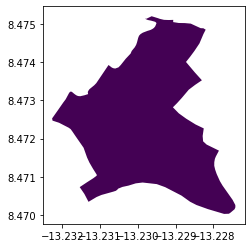

In [14]:
k_block.plot(column='k_complexity', cmap = 'viridis')


#### Calculate *k*-complexity layers which is useful for inspecting blocks (returns several records for each building layer within a block)

In [15]:
%%time
k_layers = compute_layers(block_data = gadm_blocks, 
                        bldg_data = block_coded_buildings, 
                        block_col = 'block_id', 
                        block_id = 'SLE.4.2.1_1_50', 
                        street_linestrings=osm_highways) # ecopia_highways


CPU times: user 1.59 s, sys: 25.5 ms, total: 1.61 s
Wall time: 1.57 s


<AxesSubplot:>

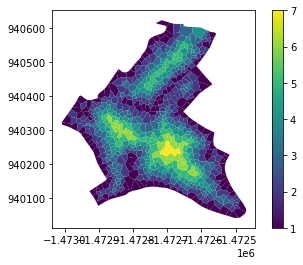

In [16]:
k_layers.plot(column='k_complexity', legend=True, cmap = 'viridis')


#### Test *k*-function on a series of blocks

In [17]:
test_sequence = ['SLE.4.2.1_1_1021', 'SLE.4.2.1_1_1081', 'SLE.4.2.1_1_1135', 'SLE.4.2.1_1_1452', 
                 'SLE.4.2.1_1_150', 'SLE.4.2.1_1_18', 'SLE.4.2.1_1_189', 'SLE.4.2.1_1_279', 
                 'SLE.4.2.1_1_300', 'SLE.4.2.1_1_415', 'SLE.4.2.1_1_497', 'SLE.4.2.1_1_516', 
                 'SLE.4.2.1_1_57', 'SLE.4.2.1_1_633', 'SLE.4.2.1_1_674', 'SLE.4.2.1_1_677', 
                 'SLE.4.2.1_1_678', 'SLE.4.2.1_1_718', 'SLE.4.2.1_1_723', 'SLE.4.2.1_1_724', 
                 'SLE.4.2.1_1_725', 'SLE.4.2.1_1_757', 'SLE.4.2.1_1_760', 'SLE.4.2.1_1_852', 
                 'SLE.4.2.1_1_960', 'SLE.4.2.1_1_961', 'SLE.4.2.1_1_966']

#### Run *k*-function serially across blocks

In [18]:
%%time
sequence_list = test_sequence
results_serial = gpd.GeoDataFrame(columns = ['block_id', 'gadm_code', 'country_code', 
                                           'block_area', 'building_area', 'building_count', 
                                           'building_layers', 'k_complexity', 'geometry']).set_crs(epsg=4326)
block_metrics = []
for x in sequence_list: 
    df_k = compute_k(block_data = gadm_blocks,
                     bldg_data = block_coded_buildings, 
                     block_col = 'block_id', 
                     block_id = x,
                     street_linestrings = osm_highways)
    block_metrics.append(df_k)
        
results_serial = results_serial.append(block_metrics, ignore_index=True)


CPU times: user 12.3 s, sys: 354 ms, total: 12.7 s
Wall time: 12.5 s


<AxesSubplot:>

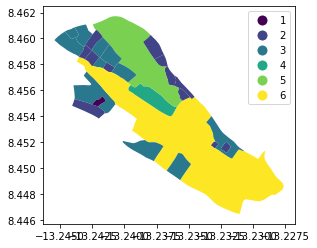

In [19]:
results_serial.plot(column='k_complexity', legend=True, cmap = 'viridis')


#### Run *k*-function across 2-partitions of blocks in parallel

In [20]:
%%time
bag_sequence = db.from_sequence(test_sequence, npartitions=2) # adjust partitions
compute_sequence = bag_sequence.map(lambda x: compute_k(block_data = gadm_blocks,
                              bldg_data = block_coded_buildings, 
                              block_col = 'block_id', 
                              block_id = x,
                              street_linestrings = osm_highways))

output_sequence = compute_sequence.compute()
#output_sequence = compute_sequence.persist() # use when on a cluster
results_parallel = gpd.GeoDataFrame(columns = ['block_id', 'gadm_code', 'country_code', 
                                      'block_area', 'building_area', 'building_count', 
                                      'building_layers', 'k_complexity', 'geometry']).set_crs(epsg=4326)

for i,j in enumerate(output_sequence): results_parallel = results_parallel.append(output_sequence[i], 
                                                                                  ignore_index=True)


CPU times: user 5.29 s, sys: 794 ms, total: 6.08 s
Wall time: 16.2 s


In [21]:
#results_parallel.plot(column='k_complexity', legend=True, cmap = 'viridis')

#### Run serialized computation over *n* GADM areas, subdivide into *n* blocks, and serially iterate through hundreds of blocks

In [22]:
%%time
k_output_serial = gpd.GeoDataFrame(columns = ['block_id', 'gadm_code', 'country_code', 
                                           'block_area', 'building_area', 'building_count', 
                                           'building_layers', 'k_complexity', 'geometry']).set_crs(epsg=4326)
for i in gadm_list[1:2]: 
    gadm_blocks = build_blocks(gadm_data = gadm_gpd, 
                               osm_data = osm_pygeos, 
                               gadm_level = gadm_level,
                               gadm_code = i)

    gadm_blocks_list = list(gadm_blocks['block_id'].unique())
    
    building_file = list(filter(re.compile(str("%s" % i +'.geojson')).findall, sorted(building_files)))[0]
    building_gpd = gpd.read_file(str(building_path + country_code + '/' + building_file)).to_crs(epsg=4326)
    
    block_coded_buildings = index_buildings(gadm_block_data = gadm_blocks, 
                                            bldg_data = building_gpd)
    
    block_metrics = []
    
    for x in gadm_blocks_list: 
        df_k = compute_k(block_data = gadm_blocks,
                         bldg_data = block_coded_buildings, 
                         block_col = 'block_id', 
                         block_id = x,
                         street_linestrings = osm_highways)
        block_metrics.append(df_k)
        
    k_output_serial = k_output_serial.append(block_metrics, ignore_index=True)



CPU times: user 1min 4s, sys: 2.05 s, total: 1min 6s
Wall time: 1min 5s


In [23]:
k_output_serial.head(10)

,block_id,gadm_code,country_code,block_area,building_area,building_count,building_layers,k_complexity,geometry
0,SLE.1.1.2_1_0,SLE.1.1.2_1,SLE,32814030.79,29160.87,465,"159,200,88,14,4",5,"POLYGON ((-10.99324 7.83366, -10.99322 7.83454..."
1,SLE.1.1.2_1_1,SLE.1.1.2_1,SLE,82795637.08,39242.52,728,"270,303,134,21",4,"POLYGON ((-10.96699 7.77914, -10.96660 7.77911..."
2,SLE.1.1.2_1_2,SLE.1.1.2_1,SLE,10540446.51,15084.58,252,"67,89,67,25,4",5,"POLYGON ((-10.93411 7.83798, -10.93391 7.83814..."
3,SLE.1.1.2_1_3,SLE.1.1.2_1,SLE,20948405.32,25262.90,365,"73,120,104,54,14",5,"POLYGON ((-11.01570 7.88252, -11.01565 7.88273..."
4,SLE.1.1.2_1_4,SLE.1.1.2_1,SLE,9024868.63,6420.80,122,"40,42,34,6",4,"POLYGON ((-10.96316 7.89072, -10.96315 7.89080..."
5,SLE.1.1.2_1_5,SLE.1.1.2_1,SLE,3112788.87,5896.44,94,"53,29,12",3,"POLYGON ((-10.95480 7.80478, -10.95463 7.80480..."
6,SLE.1.1.2_1_6,SLE.1.1.2_1,SLE,56379834.93,118115.05,1629,"525,581,344,137,35,7",6,"POLYGON ((-10.84395 7.97945, -10.84342 7.97969..."
7,SLE.1.1.2_1_7,SLE.1.1.2_1,SLE,12842544.32,4896.35,79,"31,32,16",3,"POLYGON ((-11.00613 7.82986, -11.00593 7.83022..."
8,SLE.1.1.2_1_8,SLE.1.1.2_1,SLE,32769221.11,24626.47,490,"220,209,54,7",4,"POLYGON ((-10.88551 7.89431, -10.88548 7.89567..."
9,SLE.1.1.2_1_9,SLE.1.1.2_1,SLE,14693916.39,21901.81,358,"113,137,74,31,3",5,"POLYGON ((-10.93804 7.90968, -10.93799 7.90990..."


#### Run serialized computation over *n* GADM areas, subdivide into *n* blocks, and parallelize block-level computation

In [25]:
%%time
k_output_parallel = gpd.GeoDataFrame(columns = ['block_id', 'gadm_code', 'country_code', 
                                           'block_area', 'building_area', 'building_count', 
                                           'building_layers', 'k_complexity', 'geometry']).set_crs(epsg=4326)
for i in gadm_list[1:2]: 
    gadm_blocks = build_blocks(gadm_data = gadm_gpd, 
                               osm_data = osm_pygeos, 
                               gadm_level = gadm_level,
                               gadm_code = i)

    gadm_blocks_list = list(gadm_blocks['block_id'].unique())
    
    building_file = list(filter(re.compile(str("%s" % i +'.geojson')).findall, sorted(building_files)))[0]
    building_gpd = gpd.read_file(str(building_path + country_code + '/' + building_file)).to_crs(epsg=4326)
    
    block_coded_buildings = index_buildings(gadm_block_data = gadm_blocks, 
                                            bldg_data = building_gpd)
    
    bag_sequence = db.from_sequence(gadm_blocks_list, npartitions=2)
    compute_sequence = bag_sequence.map(lambda x: compute_k(block_data = gadm_blocks,
                                                bldg_data = block_coded_buildings, 
                                                block_col = 'block_id', 
                                                block_id = x,
                                                street_linestrings = osm_highways))
    output_sequence = compute_sequence.compute()
    #output_sequence = compute_sequence.persist() # use when on a cluster
    for i,j in enumerate(output_sequence): k_output_parallel = k_output_parallel.append(output_sequence[i], 
                                                                                        ignore_index=True)



CPU times: user 9.36 s, sys: 1.08 s, total: 10.4 s
Wall time: 1min 9s


<AxesSubplot:>

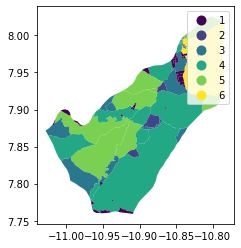

In [26]:
k_output_parallel.plot(column='k_complexity', legend=True, cmap = 'viridis')


In [27]:
k_output_parallel.head(10)

,block_id,gadm_code,country_code,block_area,building_area,building_count,building_layers,k_complexity,geometry
0,SLE.1.1.2_1_0,SLE.1.1.2_1,SLE,32814030.79,29160.87,465,"159,200,88,14,4",5,"POLYGON ((-10.99324 7.83366, -10.99322 7.83454..."
1,SLE.1.1.2_1_1,SLE.1.1.2_1,SLE,82795637.08,39242.52,728,"270,303,134,21",4,"POLYGON ((-10.96699 7.77914, -10.96660 7.77911..."
2,SLE.1.1.2_1_2,SLE.1.1.2_1,SLE,10540446.51,15084.58,252,"67,89,67,25,4",5,"POLYGON ((-10.93411 7.83798, -10.93391 7.83814..."
3,SLE.1.1.2_1_3,SLE.1.1.2_1,SLE,20948405.32,25262.90,365,"73,120,104,54,14",5,"POLYGON ((-11.01570 7.88252, -11.01565 7.88273..."
4,SLE.1.1.2_1_4,SLE.1.1.2_1,SLE,9024868.63,6420.80,122,"40,42,34,6",4,"POLYGON ((-10.96316 7.89072, -10.96315 7.89080..."
5,SLE.1.1.2_1_5,SLE.1.1.2_1,SLE,3112788.87,5896.44,94,"53,29,12",3,"POLYGON ((-10.95480 7.80478, -10.95463 7.80480..."
6,SLE.1.1.2_1_6,SLE.1.1.2_1,SLE,56379834.93,118115.05,1629,"525,581,344,137,35,7",6,"POLYGON ((-10.84395 7.97945, -10.84342 7.97969..."
7,SLE.1.1.2_1_7,SLE.1.1.2_1,SLE,12842544.32,4896.35,79,"31,32,16",3,"POLYGON ((-11.00613 7.82986, -11.00593 7.83022..."
8,SLE.1.1.2_1_8,SLE.1.1.2_1,SLE,32769221.11,24626.47,490,"220,209,54,7",4,"POLYGON ((-10.88551 7.89431, -10.88548 7.89567..."
9,SLE.1.1.2_1_9,SLE.1.1.2_1,SLE,14693916.39,21901.81,358,"113,137,74,31,3",5,"POLYGON ((-10.93804 7.90968, -10.93799 7.90990..."


## Write Outputs

#### Write GeoJSON and Parquet output

In [ ]:
k_output_parallel.to_file('/Users/nm/Desktop/kblock_freetown.geojson', driver='GeoJSON') 
warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
k_output_parallel.to_parquet('/Users/nm/Desktop/kblock_freetown.parquet')  


#### Write *k*-layer output with buildings and streets for an individual block

In [ ]:
k_layers.to_file('/Users/nm/Desktop/k_layer.geojson', driver='GeoJSON')  

k_layers_buildings = block_coded_buildings[block_coded_buildings['block_id'] == 'SLE.4.2.1_1_50'].to_crs(epsg=3395)
k_layers_buildings.to_file('/Users/nm/Desktop/k_layer_bldgs.geojson', driver='GeoJSON') 

k_layers_streets = gpd.GeoDataFrame({'streets':1,"geometry": gpd.GeoSeries(pygeos.to_shapely(osm_highways))}).set_crs(epsg=3395)
k_layers_streets.to_file('/Users/nm/Desktop/k_layer_streets.geojson', driver='GeoJSON')  